<a href="https://colab.research.google.com/github/deepeshacharya/Supply-Chain-Management/blob/main/Supply%20Chain%20and%20Order%20Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
upload = files.upload()

Saving DataCoSupplyChainDataset.csv to DataCoSupplyChainDataset.csv


In [ ]:
import pandas as pd

# --- 0. Load the Dataset ---
try:
    df = pd.read_csv('DataCoSupplyChainDataset.csv', encoding='ISO-8859-1')
    print("Dataset loaded successfully.")
    print("\nDataFrame head:\n", df.head())
    print("\nDataFrame columns:\n", df.columns.tolist())
except FileNotFoundError:
    print("Error: 'DataCoSupplyChainDataset.csv' not found. Please upload it to your environment.")
    exit() # Exit if the file is not found, as analysis cannot proceed
except Exception as e:
    print(f"An unexpected error occurred during file loading: {e}")
    exit()

# --- 1. Product Usage by Area ---
# Group by 'Category Name' and 'Order Region' and count occurrences
product_usage_by_area = df.groupby(['Category Name', 'Order Region']).size().reset_index(name='Number of Orders')
product_usage_by_area_sorted = product_usage_by_area.sort_values(by='Number of Orders', ascending=False)

print("\n--- 1. Product Usage by Area (Top 10) ---")
print(product_usage_by_area_sorted.head(10))

# --- 2. Cases with Maximum Losses ---
# Define loss as negative 'Order Profit Per Order'
losses_df = df[df['Order Profit Per Order'] < 0].copy()
losses_df['Absolute Loss'] = abs(losses_df['Order Profit Per Order'])
max_losses = losses_df.sort_values(by='Absolute Loss', ascending=False)

print("\n--- 2. Cases with Maximum Losses (Top 10) ---")
print(max_losses[['Order Id', 'Order Profit Per Order', 'Absolute Loss', 'Category Name', 'Product Name', 'Customer Country', 'Order Region']].head(10))

# --- 3. Average Benefit per Order for Delayed vs. Non-Delayed Deliveries ---
benefit_by_delivery_status = df.groupby('Late_delivery_risk')['Benefit per order'].mean().reset_index()
benefit_by_delivery_status['Late_delivery_risk'] = benefit_by_delivery_status['Late_delivery_risk'].map({0: 'Not Delayed', 1: 'Delayed'})

print("\n--- 3. Average Benefit per Order for Delayed vs. Non-Delayed Deliveries ---")
print(benefit_by_delivery_status)

# --- 4. Delivery Loss Categorized by Multiple Parameters ---
# Filter for delayed deliveries
delayed_deliveries_df = df[df['Late_delivery_risk'] == 1].copy()

# Identify loss as negative profit for delayed deliveries
delayed_losses_df = delayed_deliveries_df[delayed_deliveries_df['Order Profit Per Order'] < 0].copy()

# Group by the specified columns and calculate total loss
delivery_loss_categorized = delayed_losses_df.groupby([
    'Type',            # Payment Type
    'Category Name',   # Goods Category
    'Customer Country',
    'Customer Segment',
    'Market',
    'Product Name',
    'Shipping Mode'
])['Order Profit Per Order'].sum().reset_index(name='Total Loss')

# Sort by 'Total Loss' to see the biggest loss categories first (most negative)
delivery_loss_categorized_sorted = delivery_loss_categorized.sort_values(by='Total Loss', ascending=True)

print("\n--- 4. Delivery Loss Categorized by Multiple Parameters (Top 10 Worst Cases) ---")
print(delivery_loss_categorized_sorted.head(10))

Dataset loaded successfully.

DataFrame head:
        Type  Days for shipping (real)  Days for shipment (scheduled)  \
0     DEBIT                         3                              4   
1  TRANSFER                         5                              4   
2      CASH                         4                              4   
3     DEBIT                         3                              4   
4   PAYMENT                         2                              4   

   Benefit per order  Sales per customer   Delivery Status  \
0          91.250000          314.640015  Advance shipping   
1        -249.089996          311.359985     Late delivery   
2        -247.779999          309.720001  Shipping on time   
3          22.860001          304.809998  Advance shipping   
4         134.210007          298.250000  Advance shipping   

   Late_delivery_risk  Category Id   Category Name Customer City  ...  \
0                   0           73  Sporting Goods        Caguas  ...   
1

Cleaning the data

In [ ]:
import pandas as pd

# List of columns to keep as per the user's request, plus those implicitly needed for analysis
columns_to_keep = [
    'Type',
    'Days for shipping (real)',
    'Days for shipment (scheduled)',
    'Benefit per order',
    'Delivery Status',
    'Category Name',
    'Customer City',
    'Customer Country',
    'Customer Street',
    'Department Name',
    'Latitude',
    'Longitude',
    'Order City',
    'Order Country',
    'Product Name',
    'Shipping Mode',
    'Late_delivery_risk',        # Implicitly needed for 'late delivery correlation'
    'Order Profit Per Order'     # Implicitly needed for 'loss item relationship'
]

# Load the dataset
try:
    df = pd.read_csv('DataCoSupplyChainDataset.csv', encoding='ISO-8859-1')
    print("Dataset loaded successfully.")

    # Check if all specified columns exist in the DataFrame
    missing_columns = [col for col in columns_to_keep if col not in df.columns]
    if missing_columns:
        print(f"Warning: The following specified columns are missing from the dataset: {missing_columns}")
        # Only keep the columns that actually exist
        columns_to_keep = [col for col in columns_to_keep if col in df.columns]
        if not columns_to_keep:
            print("Error: No valid columns to proceed with after filtering. Please check column names.")
            exit()

    # Select only the specified columns
    df_cleaned = df[columns_to_keep].copy()
    print("\nDataFrame cleaned and columns selected successfully.")
    print("\nCleaned DataFrame head:\n", df_cleaned.head())
    print("\nCleaned DataFrame columns:\n", df_cleaned.columns.tolist())

except FileNotFoundError:
    print("Error: 'DataCoSupplyChainDataset.csv' not found. Please upload it to your environment.")
except Exception as e:
    print(f"An unexpected error occurred during file loading or cleaning: {e}")

Dataset loaded successfully.

DataFrame cleaned and columns selected successfully.

Cleaned DataFrame head:
        Type  Days for shipping (real)  Days for shipment (scheduled)  \
0     DEBIT                         3                              4   
1  TRANSFER                         5                              4   
2      CASH                         4                              4   
3     DEBIT                         3                              4   
4   PAYMENT                         2                              4   

   Benefit per order   Delivery Status   Category Name Customer City  \
0          91.250000  Advance shipping  Sporting Goods        Caguas   
1        -249.089996     Late delivery  Sporting Goods        Caguas   
2        -247.779999  Shipping on time  Sporting Goods      San Jose   
3          22.860001  Advance shipping  Sporting Goods   Los Angeles   
4         134.210007  Advance shipping  Sporting Goods        Caguas   

  Customer Country       


--- 1. Late Delivery Correlation with Shipping Mode ---
                On-time Delivery (%)  Late Delivery (%)
Shipping Mode                                          
First Class                 4.677501          95.322499
Same Day                   54.256958          45.743042
Second Class               23.367219          76.632781
Standard Class             61.928317          38.071683

--- 2. Loss Item Relationship with Department Name ---
       Department Name  Order Profit Per Order
3             Fan Shop           -1.810938e+06
0              Apparel           -8.265074e+05
6                 Golf           -4.831518e+05
5             Footwear           -4.410748e+05
8             Outdoors           -1.270283e+05
10          Technology           -1.119822e+05
4              Fitness           -4.076466e+04
2           Discs Shop           -2.345869e+04
7   Health and Beauty            -1.193862e+04
9             Pet Shop           -4.981990e+03
1            Book Shop           -

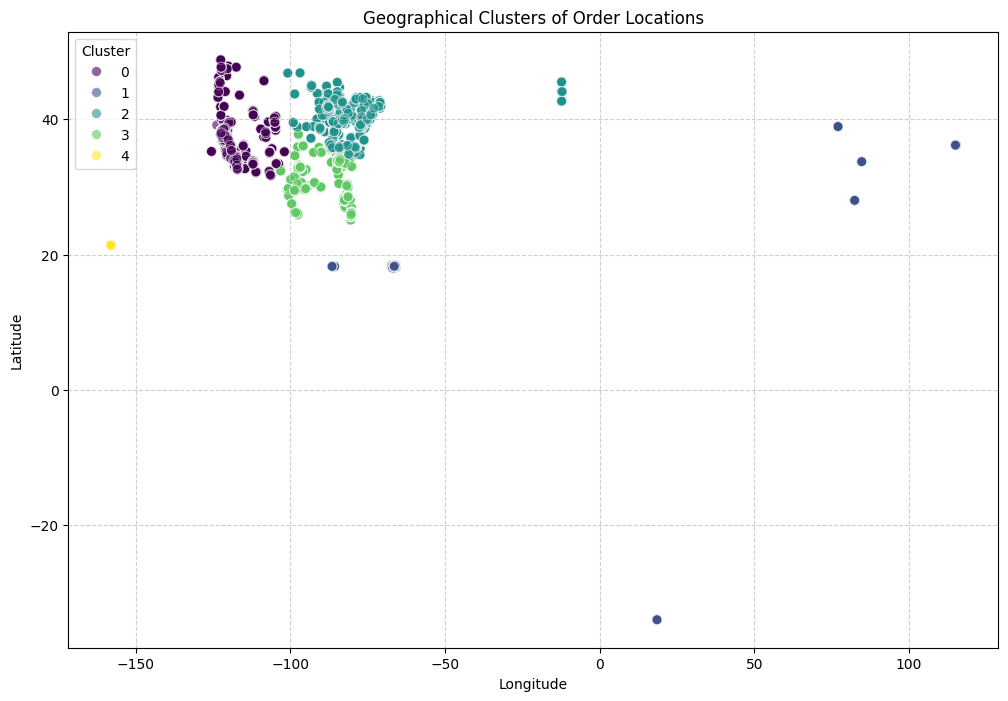

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Late Delivery Correlation with Shipping Mode ---
print("\n--- 1. Late Delivery Correlation with Shipping Mode ---")
late_delivery_by_shipping = df_cleaned.groupby('Shipping Mode')['Late_delivery_risk'].value_counts(normalize=True).unstack(fill_value=0)

# Rename columns for better readability
late_delivery_by_shipping.columns = ['On-time Delivery (%)', 'Late Delivery (%)']
late_delivery_by_shipping['On-time Delivery (%)'] = late_delivery_by_shipping['On-time Delivery (%)'] * 100
late_delivery_by_shipping['Late Delivery (%)'] = late_delivery_by_shipping['Late Delivery (%)'] * 100

print(late_delivery_by_shipping)

# --- 2. Loss Item Relationship with Department Name ---
print("\n--- 2. Loss Item Relationship with Department Name ---")
# Filter for orders with negative profit (losses)
losses_by_department = df_cleaned[df_cleaned['Order Profit Per Order'] < 0]

# Group by Department Name and sum the losses
total_losses_by_department = losses_by_department.groupby('Department Name')['Order Profit Per Order'].sum().reset_index()
total_losses_by_department = total_losses_by_department.sort_values(by='Order Profit Per Order', ascending=True) # Ascending to show largest negative (worst losses) first

print(total_losses_by_department)

# --- 3. Clustering of Areas where products are supplied more ---
print("\n--- 3. Clustering of Areas based on Product Supply (Geographical) ---")

# For clustering, we need numerical data (Latitude, Longitude)
# We'll use Order City/Country to represent the supply area, but Latitude/Longitude for clustering.
# Drop rows with missing Latitude or Longitude for clustering
geo_data = df_cleaned[['Latitude', 'Longitude', 'Order City', 'Order Country']].dropna()

if not geo_data.empty:
    # Scale the geographical data for KMeans
    scaler = StandardScaler()
    scaled_geo_features = scaler.fit_transform(geo_data[['Latitude', 'Longitude']])

    # Determine optimal number of clusters using the elbow method (for illustration, we'll pick a number)
    # In a real scenario, you'd visualize the elbow plot.
    # For now, let's choose a reasonable number of clusters, e.g., 5
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # n_init is set to 'auto' or integer in newer sklearn
    geo_data['Cluster'] = kmeans.fit_predict(scaled_geo_features)

    print(f"\nClustering performed with {n_clusters} clusters.")
    print("\nCluster centers (scaled coordinates):\n", kmeans.cluster_centers_)
    print("\nDistribution of orders per cluster:\n", geo_data['Cluster'].value_counts().sort_index())

    # To understand what each cluster represents, we can look at the most common cities/countries within each cluster
    print("\nTop 5 Order Cities per Cluster:")
    for cluster_id in range(n_clusters):
        cluster_cities = geo_data[geo_data['Cluster'] == cluster_id]['Order City'].value_counts().head(5)
        print(f"\nCluster {cluster_id}:")
        print(cluster_cities)

    # Visualization of clusters (optional, but good for understanding)
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Longitude', y='Latitude', hue='Cluster', data=geo_data, palette='viridis', s=50, alpha=0.6)
    plt.title('Geographical Clusters of Order Locations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

else:
    print("No valid geographical data (Latitude, Longitude) available for clustering after dropping NaNs.")



```
Again Calculation of Loss comparing with its Department
```



In [ ]:
import pandas as pd

# --- 0. Load and Clean Data (Re-do to ensure self-contained code) ---
# List of columns to keep, including those implicitly required for subsequent analyses
columns_to_keep = [
    'Type',
    'Days for shipping (real)',
    'Days for shipment (scheduled)',
    'Benefit per order',
    'Delivery Status',
    'Category Name',
    'Customer City',
    'Customer Country',
    'Customer Street',
    'Department Name',
    'Latitude',
    'Longitude',
    'Order City',
    'Order Country',
    'Product Name',
    'Shipping Mode',
    'Late_delivery_risk',      # Implicitly required for 'Late Delivery Correlation'
    'Order Profit Per Order',   # Implicitly required for 'Loss Item Relationship'
    'Order Item Profit Ratio',  # For product-level profitability
    'Order Item Discount',      # For discount impact analysis
    'Order Item Product Price', # For understanding discount context
    'Order Item Discount Rate'  # Explicitly added to debug KeyError
]

try:
    df = pd.read_csv('DataCoSupplyChainDataset.csv', encoding='ISO-8859-1')
    print("Original Dataset loaded successfully for loss minimization analysis.")
    print("Columns available in raw dataset:", df.columns.tolist()) # Debugging: check all columns

    # Filter out columns that do not exist in the dataframe
    existing_columns = [col for col in columns_to_keep if col in df.columns]

    # Check if any crucial columns are missing
    missing_columns = [col for col in columns_to_keep if col not in df.columns]
    if missing_columns:
        print(f"Warning: The following requested columns are missing from the dataset: {missing_columns}")

    df_cleaned = df[existing_columns].copy()

    print("\nCleaned DataFrame head for loss minimization analysis:\n", df_cleaned.head())
    print("\nCleaned DataFrame columns for loss minimization analysis:\n", df_cleaned.columns.tolist())

except FileNotFoundError:
    print("Error: 'DataCoSupplyChainDataset.csv' not found. Please upload it to your environment.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during file loading or cleaning for loss minimization: {e}")
    exit()

# --- Loss Minimization Strategy 1: Product-Level Profitability Audit in High-Loss Departments ---
print("\n--- Loss Minimization Strategy 1: Product-Level Profitability Audit ---")
high_loss_departments = ['Fan Shop', 'Apparel', 'Golf', 'Footwear']

# Filter for orders in these departments that have negative profit
loss_making_products_in_depts = df_cleaned[
    (df_cleaned['Department Name'].isin(high_loss_departments)) &
    (df_cleaned['Order Profit Per Order'] < 0)
].copy()

if not loss_making_products_in_depts.empty:
    # Group by product name and department to see total losses and average profit ratio for those products
    product_loss_summary = loss_making_products_in_depts.groupby(['Department Name', 'Product Name']).agg(
        Total_Loss=('Order Profit Per Order', 'sum'),
        Avg_Profit_Ratio=('Order Item Profit Ratio', 'mean'),
        Avg_Discount=('Order Item Discount', 'mean'),
        Avg_Product_Price=('Order Item Product Price', 'mean')
    ).reset_index()

    product_loss_summary_sorted = product_loss_summary.sort_values(by='Total_Loss', ascending=True)
    print("Top 10 Loss-Making Products in High-Loss Departments:")
    print(product_loss_summary_sorted.head(10))
else:
    print("No loss-making products found in the specified high-loss departments.")

# --- Loss Minimization Strategy 2: Financial Impact of Delays per Shipping Mode ---
print("\n--- Loss Minimization Strategy 2: Financial Impact of Delays per Shipping Mode ---")

# Group by Shipping Mode and Late_delivery_risk, then calculate average profit per order
profit_by_delivery_and_shipping = df_cleaned.groupby(['Shipping Mode', 'Late_delivery_risk'])['Order Profit Per Order'].mean().unstack(fill_value=0)

# Rename columns for clarity: 0 -> On-time, 1 -> Delayed
profit_by_delivery_and_shipping.columns = ['Avg Profit (On-time)', 'Avg Profit (Delayed)']
print(profit_by_delivery_and_shipping)

# --- Loss Minimization Strategy 3: Impact of Discounts on Profit ---
print("\n--- Loss Minimization Strategy 3: Impact of Discounts on Profit ---")

# Ensure 'Order Item Discount Rate' exists before proceeding.
if 'Order Item Discount Rate' in df_cleaned.columns:
    # Handle potential NaN in 'Order Item Discount Rate' by filling with 0
    df_cleaned['Order Item Discount Rate'].fillna(0, inplace=True)
    bins = [0, 0.01, 0.05, 0.10, 0.20, 0.30, 0.50, 1.0]
    labels = ['0%', '0.1-5%', '5.1-10%', '10.1-20%', '20.1-30%', '30.1-50%', '>50%']
    df_cleaned['Discount_Rate_Bin'] = pd.cut(df_cleaned['Order Item Discount Rate'], bins=bins, labels=labels, right=False, include_lowest=True)

    # Calculate average profit per order for each discount rate bin
    profit_by_discount_bin = df_cleaned.groupby('Discount_Rate_Bin')['Order Profit Per Order'].mean().reset_index()
    profit_by_discount_bin_sorted = profit_by_discount_bin.sort_values(by='Order Profit Per Order')

    print("Average Order Profit Per Order by Discount Rate Bin:")
    print(profit_by_discount_bin_sorted)
else:
    print("Cannot perform 'Impact of Discounts on Profit' analysis: 'Order Item Discount Rate' column not found in cleaned data.")

Original Dataset loaded successfully for loss minimization analysis.
Columns available in raw dataset: ['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Delivery Status', 'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City', 'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id', 'Customer Lname', 'Customer Password', 'Customer Segment', 'Customer State', 'Customer Street', 'Customer Zipcode', 'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market', 'Order City', 'Order Country', 'Order Customer Id', 'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status', 'Order Zipcode', 'Product Card Id', 'Product Category Id', 'Product Des

<ipython-input-7-a8bfd4a068f7>:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['Order Item Discount Rate'].fillna(0, inplace=True)
<ipython-input-7-a8bfd4a068f7>:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  profit_by_discount_bin = df_cleaned.groupby('Discount_Rate_Bin')['Order Profit Per Order'].mean().reset_index()


Forcasting Losses

Original Dataset loaded successfully for loss estimation and forecasting.

Losses DataFrame head for forecasting:
    Department Name  Order Profit Per Order order date (DateOrders) Order_Month
1          Fitness             -249.089996     2018-01-13 12:27:00     2018-01
2          Fitness             -247.779999     2018-01-13 12:06:00     2018-01
15         Fitness             -259.579987     2018-01-13 07:33:00     2018-01
16         Fitness             -246.360001     2018-01-13 07:12:00     2018-01
28         Fitness              -17.139999     2018-01-13 03:00:00     2018-01

--- 1. Aggregating Historical Monthly Losses by Department ---

Total Historical Losses by Department:
 Department Name
Fan Shop             -1.810938e+06
Apparel              -8.265074e+05
Golf                 -4.831518e+05
Footwear             -4.410748e+05
Outdoors             -1.270283e+05
Technology           -1.119822e+05
Fitness              -4.076466e+04
Discs Shop           -2.345869e+04
Health and

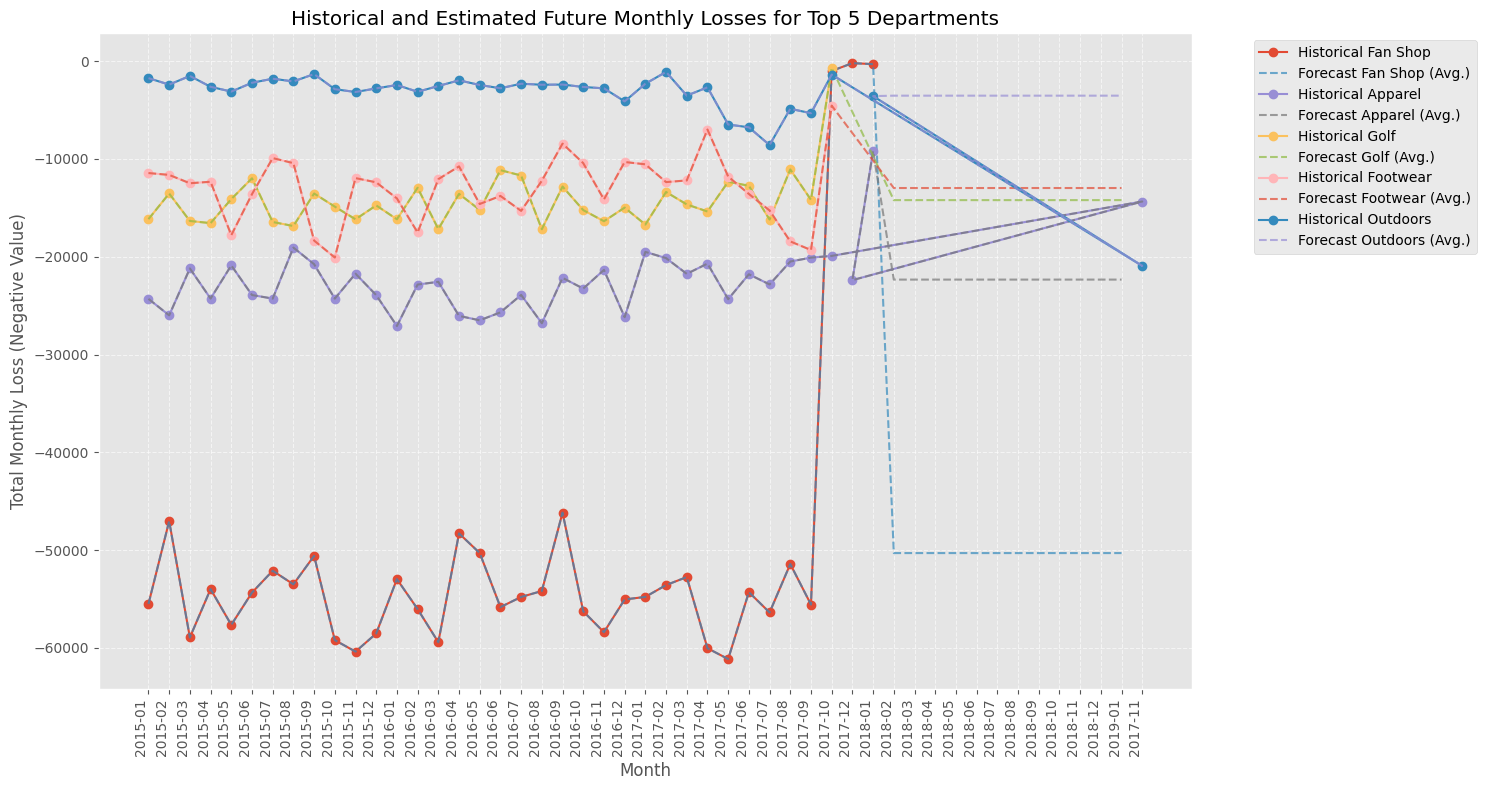

In [ ]:

# List of columns to keep for this analysis
columns_for_forecasting = [
    'Department Name',
    'Order Profit Per Order',
    'order date (DateOrders)' # Crucial for time-series analysis
]

try:
    df = pd.read_csv('DataCoSupplyChainDataset.csv', encoding='ISO-8859-1')
    print("Original Dataset loaded successfully for loss estimation and forecasting.")

    # Filter out columns that do not exist in the dataframe
    existing_columns = [col for col in columns_for_forecasting if col in df.columns]

    # Check if any crucial columns are missing
    missing_columns = [col for col in columns_for_forecasting if col not in df.columns]
    if missing_columns:
        print(f"Error: The following crucial columns are missing for forecasting: {missing_columns}. Please ensure they are in the dataset.")
        exit()

    df_losses = df[existing_columns].copy()

    # Convert 'order date (DateOrders)' to datetime objects
    df_losses['order date (DateOrders)'] = pd.to_datetime(df_losses['order date (DateOrders)'])

    # Filter for actual losses (Order Profit Per Order < 0)
    df_losses = df_losses[df_losses['Order Profit Per Order'] < 0].copy()

    if df_losses.empty:
        print("No loss data found in the dataset for forecasting.")
        exit()

    # Extract Year and Month for time series aggregation
    df_losses['Order_Month'] = df_losses['order date (DateOrders)'].dt.to_period('M')

    print("\nLosses DataFrame head for forecasting:\n", df_losses.head())

except FileNotFoundError:
    print("Error: 'DataCoSupplyChainDataset.csv' not found. Please upload it to your environment.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during file loading or preparation for loss estimation: {e}")
    exit()

# --- 1. Aggregate Historical Monthly Losses by Department ---
print("\n--- 1. Aggregating Historical Monthly Losses by Department ---")
monthly_losses = df_losses.groupby(['Department Name', 'Order_Month'])['Order Profit Per Order'].sum().reset_index()

# Sort by month for time series plotting
monthly_losses = monthly_losses.sort_values(by=['Department Name', 'Order_Month'])

# Calculate the total historical loss for each department for ranking
total_department_losses = monthly_losses.groupby('Department Name')['Order Profit Per Order'].sum().sort_values(ascending=True)

print("\nTotal Historical Losses by Department:\n", total_department_losses)

# Identify top N loss-making departments for detailed analysis and plotting
N_top_departments = 5
top_loss_departments = total_department_losses.head(N_top_departments).index.tolist()
print(f"\nTop {N_top_departments} Loss-Making Departments: {top_loss_departments}")

# --- 2. Estimate Future Losses (Simple Extrapolation based on Average Monthly Loss) ---
print("\n--- 2. Estimating Future Losses (Simple Extrapolation) ---")

# Calculate average monthly loss for each department from historical data
average_monthly_losses = monthly_losses.groupby('Department Name')['Order Profit Per Order'].mean().reset_index()
average_monthly_losses.columns = ['Department Name', 'Average_Monthly_Loss']

print("\nAverage Monthly Loss per Department:\n", average_monthly_losses)

# --- Forecasting for a future period (e.g., next 12 months) ---
future_months_to_forecast = 12
print(f"\nForecasting losses for the next {future_months_to_forecast} months based on average historical monthly loss.")

future_loss_estimation = {}
for dept in top_loss_departments:
    if dept in average_monthly_losses['Department Name'].values:
        avg_loss = average_monthly_losses[average_monthly_losses['Department Name'] == dept]['Average_Monthly_Loss'].iloc[0]
        estimated_future_loss = avg_loss * future_months_to_forecast
        future_loss_estimation[dept] = estimated_future_loss
    else:
        future_loss_estimation[dept] = 0 # No historical loss for this department

print("\nEstimated Future Loss (next 12 months) for Top Departments:")
for dept, loss in future_loss_estimation.items():
    print(f"{dept}: ${loss:,.2f}")


# --- 3. Plotting Historical and Estimated Future Losses ---
print("\n--- 3. Plotting Historical and Estimated Future Losses ---")

plt.figure(figsize=(15, 8))
plt.style.use('ggplot')

# Get the last historical month
last_historical_month = df_losses['Order_Month'].max()

for dept in top_loss_departments:
    dept_data = monthly_losses[monthly_losses['Department Name'] == dept].copy()

    if not dept_data.empty:
        # Sort data by month for correct plotting order
        dept_data = dept_data.sort_values('Order_Month')

        # Historical Plot
        plt.plot(dept_data['Order_Month'].astype(str), dept_data['Order Profit Per Order'], label=f'Historical {dept}', marker='o', linestyle='-')

        # Estimated Future Plot (if there's an average loss)
        if dept in future_loss_estimation and future_loss_estimation[dept] != 0:
            avg_loss_for_dept = average_monthly_losses[average_monthly_losses['Department Name'] == dept]['Average_Monthly_Loss'].iloc[0]

            # Create future months for plotting
            future_months_labels = pd.period_range(start=last_historical_month + 1, periods=future_months_to_forecast, freq='M').astype(str)

            # Create a line for the forecasted constant average
            forecast_values = [avg_loss_for_dept] * future_months_to_forecast

            # Extend the plot line from the last historical point to the first forecasted point
            # This requires matching the x-axis for plotting, so combine historical and future periods
            combined_periods = dept_data['Order_Month'].astype(str).tolist() + future_months_labels.tolist()
            combined_losses = dept_data['Order Profit Per Order'].tolist() + forecast_values

            plt.plot(combined_periods, combined_losses, label=f'Forecast {dept} (Avg.)', linestyle='--', alpha=0.7)


plt.title(f'Historical and Estimated Future Monthly Losses for Top {N_top_departments} Departments')
plt.xlabel('Month')
plt.ylabel('Total Monthly Loss (Negative Value)')
plt.xticks(rotation=90, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()